In [1]:
%matplotlib inline


# Faces dataset decompositions

This example applies to `olivetti_faces_dataset` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
`decompositions`).


- Authors: Vlad Niculae, Alexandre Gramfort
- License: BSD 3 clause


## Dataset preparation

Loading and preprocessing the Olivetti faces dataset.



In [13]:
import logging

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn import cluster
from sklearn import decomposition

rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces - faces.mean(axis=0)

# Local centering (focus on one sample, centering all features)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


Define a base function to plot the gallery of faces.



In [3]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

Let’s take a look at our data. Gray color indicates negative values,
white indicates positive values.



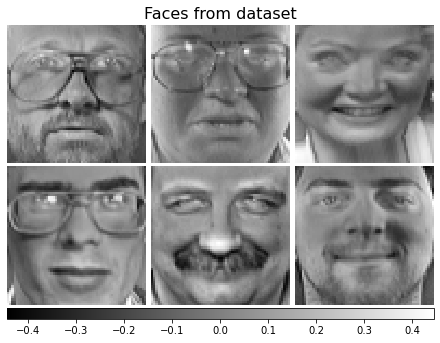

In [4]:
plot_gallery("Faces from dataset", faces_centered[:n_components])

## Decomposition

Initialise different estimators for decomposition and fit each
of them on all images and plot some results. Each estimator extracts
6 components as vectors $h \in \mathbb{R}^{4096}$.
We just displayed these vectors in human-friendly visualisation as 64x64 pixel images.

Read more in the `User Guide <decompositions>`.



### Eigenfaces - PCA using randomized SVD
Linear dimensionality reduction using Singular Value Decomposition (SVD) of the data
to project it to a lower dimensional space.


<div class="alert alert-info"><h4>Note</h4><p>The Eigenfaces estimator, via the :py:mod:`sklearn.decomposition.PCA`,
    also provides a scalar `noise_variance_` (the mean of pixelwise variance)
    that cannot be displayed as an image.</p></div>



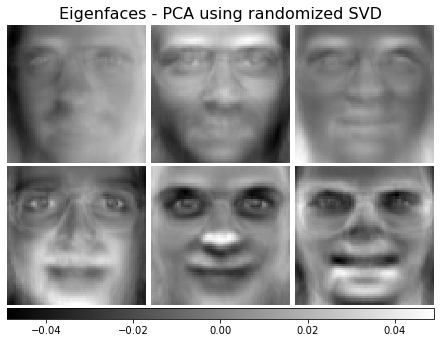

In [5]:
pca_estimator = decomposition.PCA(
    n_components=n_components, svd_solver="randomized", whiten=True
)
pca_estimator.fit(faces_centered)
plot_gallery(
    "Eigenfaces - PCA using randomized SVD", pca_estimator.components_[:n_components]
)

### Non-negative components - NMF

Estimate non-negative original data as production of two non-negative matrices.



C:\Users\a1056968\Anaconda3\envs\math_for_devs\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\a1056968\Anaconda3\envs\math_for_devs\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


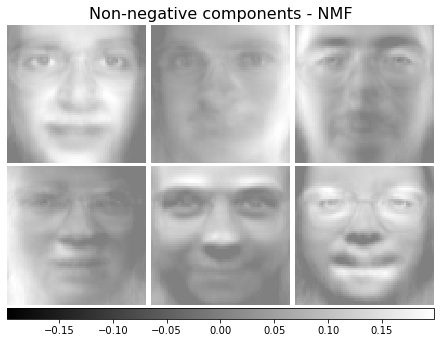

In [6]:
nmf_estimator = decomposition.NMF(n_components=n_components, tol=5e-3)
nmf_estimator.fit(faces)  # original non- negative dataset
plot_gallery("Non-negative components - NMF", nmf_estimator.components_[:n_components])

### Independent components - FastICA
Independent component analysis separates a multivariate vectors into additive
subcomponents that are maximally independent.



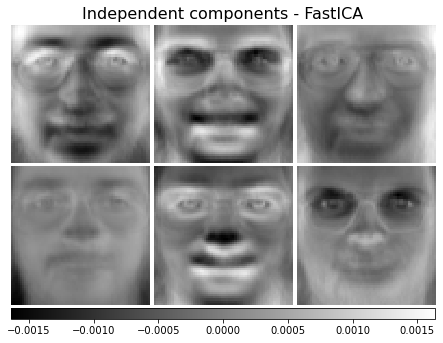

In [7]:
ica_estimator = decomposition.FastICA(
    n_components=n_components, max_iter=400, whiten="arbitrary-variance", tol=15e-5
)
ica_estimator.fit(faces_centered)
plot_gallery(
    "Independent components - FastICA", ica_estimator.components_[:n_components]
)

### Sparse components - MiniBatchSparsePCA

Mini-batch sparse PCA (`MiniBatchSparsePCA`) extracts the set of sparse
components that best reconstruct the data. This variant is faster but
less accurate than the similar :py:mod:`sklearn.decomposition.SparsePCA`.



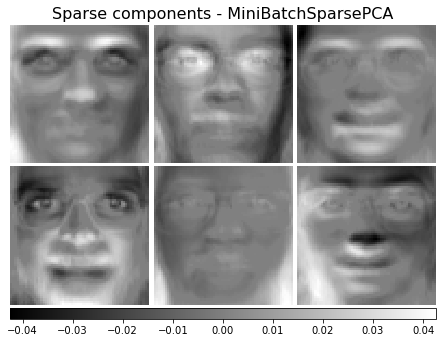

In [8]:
batch_pca_estimator = decomposition.MiniBatchSparsePCA(
    n_components=n_components, alpha=0.1, n_iter=100, batch_size=3, random_state=rng
)
batch_pca_estimator.fit(faces_centered)
plot_gallery(
    "Sparse components - MiniBatchSparsePCA",
    batch_pca_estimator.components_[:n_components],
)

### Dictionary learning

By default, :class:`MiniBatchDictionaryLearning` divides the data into
mini-batches and optimizes in an online manner by cycling over the
mini-batches for the specified number of iterations.



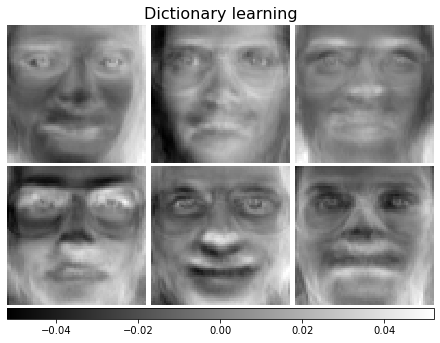

In [9]:
batch_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components, alpha=0.1, n_iter=50, batch_size=3, random_state=rng
)
batch_dict_estimator.fit(faces_centered)
plot_gallery("Dictionary learning", batch_dict_estimator.components_[:n_components])

### Cluster centers - MiniBatchKMeans

`MiniBatchKMeans` is computationally efficient and implements on-line
learning with a `partial_fit` method. That is why it could be beneficial
to enhance some time-consuming algorithms with  `MiniBatchKMeans`.



C:\Users\a1056968\Anaconda3\envs\math_for_devs\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


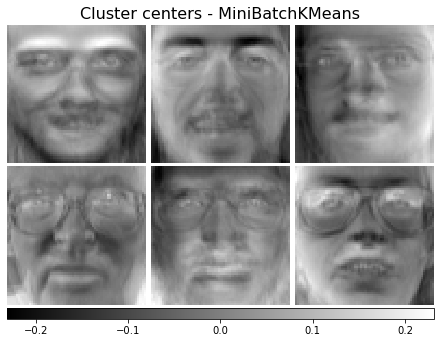

In [10]:
kmeans_estimator = cluster.MiniBatchKMeans(
    n_clusters=n_components,
    tol=1e-3,
    batch_size=20,
    max_iter=50,
    random_state=rng,
)
kmeans_estimator.fit(faces_centered)
plot_gallery(
    "Cluster centers - MiniBatchKMeans",
    kmeans_estimator.cluster_centers_[:n_components],
)

### Factor Analysis components - FA

`Factor Analysis` is similar to `PCA` but has the advantage of modelling the
variance in every direction of the input space independently
(heteroscedastic noise).
Read more in the `User Guide <FA>`.



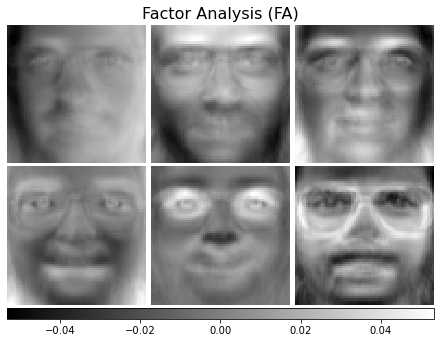

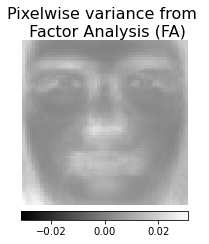

In [11]:
fa_estimator = decomposition.FactorAnalysis(n_components=n_components, max_iter=20)
fa_estimator.fit(faces_centered)
plot_gallery("Factor Analysis (FA)", fa_estimator.components_[:n_components])

# --- Pixelwise variance
plt.figure(figsize=(3.2, 3.6), facecolor="white", tight_layout=True)
vec = fa_estimator.noise_variance_
vmax = max(vec.max(), -vec.min())
plt.imshow(
    vec.reshape(image_shape),
    cmap=plt.cm.gray,
    interpolation="nearest",
    vmin=-vmax,
    vmax=vmax,
)
plt.axis("off")
plt.title("Pixelwise variance from \n Factor Analysis (FA)", size=16, wrap=True)
plt.colorbar(orientation="horizontal", shrink=0.8, pad=0.03)
plt.show()

## Decomposition: Dictionary learning

In the further section, let's consider `DictionaryLearning` more precisely.
Dictionary learning is a problem that amounts to finding a sparse representation
of the input data as a combination of simple elements. These simple elements form
a dictionary. It is possible to constrain the dictionary and/or coding coefficients
to be positive to match constraints that may be present in the data.

:class:`MiniBatchDictionaryLearning` implements a faster, but less accurate
version of the dictionary learning algorithm that is better suited for large
datasets. Read more in the `User Guide <MiniBatchDictionaryLearning>`.



Plot the same samples from our dataset but with another colormap.
Red indicates negative values, blue indicates positive values,
and white represents zeros.



In [ ]:
plot_gallery("Faces from dataset", faces_centered[:n_components], cmap=plt.cm.RdBu)

Similar to the previous examples, we change parameters and train
`MiniBatchDictionaryLearning` estimator on all images. Generally,
the dictionary learning and sparse encoding decompose input data
into the dictionary and the coding coefficients matrices.
$X \approx UV$, where $X = [x_1, . . . , x_n]$,
$X \in \mathbb{R}^{m×n}$, dictionary $U \in \mathbb{R}^{m×k}$, coding
coefficients $V \in \mathbb{R}^{k×n}$.

Also below are the results when the dictionary and coding
coefficients are positively constrained.



### Dictionary learning - positive dictionary

In the following section we enforce positivity when finding the dictionary.



In [ ]:
dict_pos_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    n_iter=50,
    batch_size=3,
    random_state=rng,
    positive_dict=True,
)
dict_pos_dict_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive dictionary",
    dict_pos_dict_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

### Dictionary learning - positive code

Below we constrain the coding coefficients as a positive matrix.



In [ ]:
dict_pos_code_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    n_iter=50,
    batch_size=3,
    fit_algorithm="cd",
    random_state=rng,
    positive_code=True,
)
dict_pos_code_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive code",
    dict_pos_code_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

### Dictionary learning - positive dictionary & code

Also below are the results if the dictionary values and coding
coefficients are positively constrained.



In [ ]:
dict_pos_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    n_iter=50,
    batch_size=3,
    fit_algorithm="cd",
    random_state=rng,
    positive_dict=True,
    positive_code=True,
)
dict_pos_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive dictionary & code",
    dict_pos_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)